<a href="https://colab.research.google.com/gist/roxdm/1e2af006862f4d25eeffc4dd6a564397/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational Auto-Encoders
=========================
This code implements a Variation Auto-Encoder (VAE). If using Google Colab, please activate the use of the GPU (Edit -> Notebok Settings).

In [1]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    !pip3 install torch torchvision #--index-url https://download.pytorch.org/whl/cu118 #uncomment to enforce cuda 11.8

if 'google.colab' in sys.modules and 'tqdm' not in sys.modules:
    !pip3 install tqdm


%matplotlib inline
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from matplotlib import gridspec

import os
if os.path.exists('./training') == False:
  os.mkdir('./training')

Hyper-Parameters
----------------

In [22]:
batch_size = 100     # batch size
latent_dim = 8      # latent-space dimension
num_channels = (128, 256, 384)
num_res_blocks = 1
norm_groups = 32
attention_levels = (False, False, True)
middle_dim = 96      # size of the middle layer
learning_rate = 5e-5  # learning rate
max_epochs = 50       # maximum number of epochs
use_gpu = True        # using the GPU
kl_weight = 0.1  # Start with a smaller weight for KL loss (adjust as needed)


Loading the Dataset
-------------------
The MedNIST dataset will be used, more specifically the hand CT images from the dataset. These are sized 64x64.

In [3]:

input_dim = 28**2

In [4]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

c:\Users\roxan\AppData\Local\Programs\Python\Python312\Lib\site-packages\ignite\handlers\checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
2025-05-27 12:01:03.753305: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 12:01:07.214160: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [5]:
import os
import shutil
import tempfile
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from torch.nn import L1Loss
from tqdm import tqdm

from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import AutoencoderKL, PatchDiscriminator

c:\Users\roxan\AppData\Local\Programs\Python\Python312\Lib\site-packages\ignite\handlers\checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


In [6]:

# image dimensions
input_dim = 64*64

from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from torch.nn import L1Loss
from tqdm import tqdm

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
image_size = 64
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)


C:\Users\roxan\AppData\Local\Temp\Mxt242\var\log\xwin\tmp38jekz1n


MedNIST.tar.gz: 59.0MB [00:46, 1.32MB/s]                              

2025-05-27 12:02:08,879 - INFO - Downloaded: C:\Users\roxan\AppData\Local\Temp\Mxt242\var\log\xwin\tmp38jekz1n\MedNIST.tar.gz


2025-05-27 12:02:09,003 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2025-05-27 12:02:09,003 - INFO - Writing into directory: C:\Users\roxan\AppData\Local\Temp\Mxt242\var\log\xwin\tmp38jekz1n.


Loading dataset: 100%|██████████| 47164/47164 [1:34:29<00:00,  8.32it/s]      


In [7]:
train_ds = Dataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)

val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
test_dataloader = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

2025-05-27 13:37:17,122 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2025-05-27 13:37:17,122 - INFO - File exists: C:\Users\roxan\AppData\Local\Temp\Mxt242\var\log\xwin\tmp38jekz1n\MedNIST.tar.gz, skipped downloading.
2025-05-27 13:37:17,122 - INFO - Non-empty folder exists in C:\Users\roxan\AppData\Local\Temp\Mxt242\var\log\xwin\tmp38jekz1n\MedNIST, skipped extracting.


Loading dataset: 100%|██████████| 5895/5895 [00:48<00:00, 121.02it/s]


VAE Definition
--------------
We will now use a specific scheme to initialize our weights, called Xavier initialization. You can neglect this if you are using other layers than fully connected.

In [23]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [17]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, norm_groups=32):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm = nn.GroupNorm(norm_groups, out_channels)
        self.activation = nn.SiLU()  # Swish activation used in many modern autoencoders
        
    def forward(self, x):
        return self.activation(self.norm(self.conv(x)))

The following model represents the distribution encoder distribution q(z|x), together with the reparametrization trick.

In [18]:
class Q(nn.Module):
    def __init__(self, in_channels=1, latent_channels=8, num_channels=(128, 256, 384), 
                 num_res_blocks=1, norm_groups=32, attention_levels=(False, False, True)):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, num_channels[0], 3, padding=1)
        
        # Downsampling blocks
        self.down_blocks = nn.ModuleList()
        current_channels = num_channels[0]
        
        for i, channels in enumerate(num_channels):
            block = nn.ModuleList()
            
            # Residual blocks
            for _ in range(num_res_blocks):
                block.append(ResBlock(current_channels, norm_groups))
            
            # Attention (simplified - you might want to implement proper attention)
            if attention_levels[i]:
                block.append(nn.MultiheadAttention(current_channels, 8, batch_first=True))
            
            # Downsample (except for last block)
            if i < len(num_channels) - 1:
                block.append(nn.Conv2d(current_channels, channels, 4, stride=2, padding=1))
                current_channels = channels
            
            self.down_blocks.append(block)
        
        # Final convolution to latent space
        self.conv_out_mu = nn.Conv2d(current_channels, latent_channels, 3, padding=1)
        self.conv_out_var = nn.Conv2d(current_channels, latent_channels, 3, padding=1)


    def forward(self, x):
        x = self.conv_in(x)
        
        for block in self.down_blocks:
            for layer in block:
                if isinstance(layer, nn.MultiheadAttention):
                    # Flatten for attention, then reshape back
                    b, c, h, w = x.shape
                    x_flat = x.view(b, c, h*w).transpose(1, 2)
                    x_flat, _ = layer(x_flat, x_flat, x_flat)
                    x = x_flat.transpose(1, 2).view(b, c, h, w)
                else:
                    x = layer(x)
        
        mu = self.conv_out_mu(x)
        log_var = self.conv_out_var(x)
        return mu, log_var
    
class ResBlock(nn.Module):
    def __init__(self, channels, norm_groups=32):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(norm_groups, channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(norm_groups, channels)
        self.activation = nn.SiLU()
        
    def forward(self, x):
        residual = x
        x = self.activation(self.norm1(self.conv1(x)))
        x = self.norm2(self.conv2(x))
        return self.activation(x + residual)

We now model the reparametrization trick.

In [31]:
class Reparametrization(nn.Module):
  def __init__(self):
    super(Reparametrization, self).__init__()

  def forward(self, z_mu, z_var):
    eps = torch.randn(z_var.size(0), z_var.size(1), device=device) # sample on a unit Gaussian
    eps = torch.randn_like(z_var)
    return z_mu + torch.exp(z_var/2) * eps

The following model represents the decoder P(x|z).

In [20]:
class P(nn.Module):
    def __init__(self, out_channels=1, latent_channels=8, num_channels=(384, 256, 128),
                 num_res_blocks=1, norm_groups=32):
        super().__init__()
        self.conv_in = nn.Conv2d(latent_channels, num_channels[0], 3, padding=1)
        
        # Upsampling blocks
        self.up_blocks = nn.ModuleList()
        current_channels = num_channels[0]
        
        for i, channels in enumerate(num_channels[1:] + (out_channels,)):
            block = nn.ModuleList()
            
            # Residual blocks
            for _ in range(num_res_blocks):
                block.append(ResBlock(current_channels, norm_groups))
            
            # Upsample
            if i < len(num_channels):
                block.append(nn.ConvTranspose2d(current_channels, channels, 4, stride=2, padding=1))
                current_channels = channels
            
            self.up_blocks.append(block)
        
        self.conv_out = nn.Conv2d(current_channels, out_channels, 3, padding=1)
        self.final_activation = nn.Sigmoid()  # For pixel values in [0,1]
    
    def forward(self, x):
        x = self.conv_in(x)
        
        for block in self.up_blocks:
            for layer in block:
                x = layer(x)
        
        x = self.conv_out(x)
        return self.final_activation(x)


Training
--------

We first initialize an instance of the model and load it onto GPU if relevant.

In [33]:
# creating instances of the model
q = Q(in_channels=1, latent_channels=latent_dim, num_channels=num_channels, 
            num_res_blocks=num_res_blocks, norm_groups=norm_groups, attention_levels=attention_levels)
p = P(out_channels=1, latent_channels=latent_dim, num_channels=num_channels[::-1], 
            num_res_blocks=num_res_blocks, norm_groups=norm_groups)
reparam = Reparametrization()

# loading them onto the GPU if relevant
if use_gpu and torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Using the GPU (faster).")
else:
  device = torch.device("cpu")
  print("Using the CPU.")

q = q.to(device)
p = p.to(device)
reparam = reparam.to(device)

# computing the number of parameters
num_params_gen = sum(param.numel() for param in p.parameters() if param.requires_grad)
num_params_disc = sum(param.numel() for param in q.parameters() if param.requires_grad)
print('Number of parameters for encoder: %d and decoder: %d' % (num_params_gen, num_params_disc))

Using the CPU.
Number of parameters for encoder: 6261003 and decoder: 2860688


We can now do the training properly speaking.

In [ ]:
# Training setup
q.train()
p.train()
reparam.train()

parameters = list(p.parameters()) + list(q.parameters())
optim = torch.optim.Adam(parameters, lr=learning_rate, betas=(0.15, 0.999))
bce = nn.BCELoss(reduction='mean')

total_losses = []
recon_losses = []
kl_losses = []
current_image = 0

print('Training...')
for epoch in range(max_epochs):
    avg_total_loss = 0
    avg_recon_loss = 0
    avg_kl_loss = 0
    num_batches = 0
    
    for batch_idx, batch_data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
    # Extract image from MedNIST batch
        if isinstance(batch_data, dict):
            batch = batch_data['image']
        elif isinstance(batch_data, (list, tuple)):
            batch = batch_data[0]  # Take first element if it's a tuple/list
        else:
            batch = batch_data
        
        # Convert MONAI MetaTensor to regular tensor if needed
        if hasattr(batch, 'as_tensor'):
            batch = batch.as_tensor()
        
        batch = batch.to(device)
        
        # Debug: Print batch shape to understand the issue
        if batch_idx == 0 and epoch == 0:
            print(f"Batch shape: {batch.shape}")
            print(f"Batch size: {batch.size(0)}")
        
        # Ensure we have the right dimensions [batch_size, channels, height, width]
        if batch.dim() == 3:  # [batch_size, height, width] - add channel dimension
            batch = batch.unsqueeze(1)
        elif batch.dim() == 2:  # [batch_size, flattened] - reshape to image format
            # Assuming square images, calculate side length
            batch_size = batch.size(0)
            total_pixels = batch.size(1)
            side_length = int(total_pixels ** 0.5)
            batch = batch.view(batch_size, 1, side_length, side_length)
        elif batch.dim() == 4:  # [batch_size, channels, height, width] - normal case
            pass  # Keep as is - this is the correct format for convolutional layers
        else:
            raise ValueError(f"Unexpected batch dimensions: {batch.shape}")
        
        # Forward pass
        z_mu, z_var = q(batch)
        print(f"z_mu shape: {z_mu.shape}, z_var shape: {z_var.shape}")  # Debugging line
        # Reparameterization trick
        z = reparam(z_mu, z_var)
        batch_recon = p(z)
        batch_recon = nn.functional.interpolate(batch_recon, size=(64, 64), mode="bilinear", align_corners=False)

        # Reconstruction loss E[log P(X|z)]
        recon_loss = bce(batch_recon, batch)
        
        # KL divergence loss D_KL(Q(z|X) || P(z))
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu ** 2 - 1. - z_var, 1))
        
        # Total loss
        total_loss = recon_loss + kl_weight*kl_loss
        
        # Backward pass
        optim.zero_grad()
        total_loss.backward()
        optim.step()
        
        # Accumulate losses
        avg_total_loss += total_loss.item()
        avg_recon_loss += recon_loss.item()
        avg_kl_loss += kl_loss.item()
        num_batches += 1
    
    # Calculate average losses
    avg_total_loss /= num_batches
    avg_recon_loss /= num_batches
    avg_kl_loss /= num_batches
    
    total_losses.append(avg_total_loss)
    recon_losses.append(avg_recon_loss)
    kl_losses.append(avg_kl_loss)
    
    print(f"\t[Losses] Total {total_losses[-1]:.3f} - Recon. {recon_losses[-1]:.3f} - KL {kl_losses[-1]:.3f}")
    
    # Generate and save samples
    if epoch % 2 == 0:
        with torch.no_grad():
            # Sample from latent space
            #z_sample = torch.randn(16, latent_dim).to(device)
            sample_shape = z_mu.shape  # or z.shape
            z_sample = torch.randn(sample_shape).to(device)
            samples = p(z_sample).data.cpu().numpy()

            plt.close('all')
            fig = plt.figure(figsize=(8, 8))
            gs = gridspec.GridSpec(4, 4)
            gs.update(wspace=0.05, hspace=0.05)
            
            for i, sample in enumerate(samples):
                ax = plt.subplot(gs[i])
                plt.axis('off')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')
                # Reshape back to 64x64 for display
                plt.imshow(sample.squeeze(), cmap='gray')
            
            # Create output directory
            if not os.path.exists('training/'):
                os.makedirs('training/')
            
            plt.savefig(f'training/{epoch}_{str(current_image).zfill(3)}.png', 
                       bbox_inches='tight', dpi=100)
            current_image += 1
            plt.close(fig)

print("Training completed!")

Training...


Epoch 0:   0%|          | 0/80 [00:00<?, ?it/s]

Batch shape: torch.Size([100, 1, 64, 64])
Batch size: 100
z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:   1%|▏         | 1/80 [00:24<32:01, 24.32s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:   2%|▎         | 2/80 [00:46<29:45, 22.89s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:   4%|▍         | 3/80 [01:06<28:08, 21.93s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:   5%|▌         | 4/80 [01:27<27:18, 21.56s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:   6%|▋         | 5/80 [01:49<26:49, 21.46s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:   8%|▊         | 6/80 [02:14<28:09, 22.83s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:   9%|▉         | 7/80 [02:40<28:46, 23.65s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  10%|█         | 8/80 [03:04<28:46, 23.97s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  11%|█▏        | 9/80 [03:31<29:18, 24.76s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  12%|█▎        | 10/80 [04:06<32:42, 28.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  14%|█▍        | 11/80 [04:35<32:33, 28.31s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  15%|█▌        | 12/80 [05:04<32:19, 28.53s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  16%|█▋        | 13/80 [05:32<31:30, 28.21s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  18%|█▊        | 14/80 [05:57<29:57, 27.24s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  19%|█▉        | 15/80 [06:25<29:46, 27.48s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  20%|██        | 16/80 [06:53<29:33, 27.71s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  21%|██▏       | 17/80 [07:22<29:24, 28.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  22%|██▎       | 18/80 [07:50<29:05, 28.15s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  24%|██▍       | 19/80 [08:21<29:26, 28.95s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  25%|██▌       | 20/80 [08:51<29:14, 29.24s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  26%|██▋       | 21/80 [09:26<30:26, 30.95s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  28%|██▊       | 22/80 [09:52<28:41, 29.68s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  29%|██▉       | 23/80 [10:18<27:01, 28.44s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  30%|███       | 24/80 [10:43<25:27, 27.28s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  31%|███▏      | 25/80 [11:08<24:27, 26.69s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  32%|███▎      | 26/80 [11:32<23:25, 26.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  34%|███▍      | 27/80 [11:57<22:33, 25.54s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  35%|███▌      | 28/80 [12:22<21:57, 25.34s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  36%|███▋      | 29/80 [12:46<21:20, 25.11s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  38%|███▊      | 30/80 [13:11<20:50, 25.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  39%|███▉      | 31/80 [13:35<20:14, 24.78s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  40%|████      | 32/80 [14:00<19:50, 24.81s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  41%|████▏     | 33/80 [14:27<19:51, 25.34s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  42%|████▎     | 34/80 [14:53<19:41, 25.68s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  44%|████▍     | 35/80 [15:29<21:31, 28.69s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  45%|████▌     | 36/80 [16:02<22:01, 30.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  46%|████▋     | 37/80 [16:37<22:33, 31.48s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  48%|████▊     | 38/80 [17:05<21:14, 30.35s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  49%|████▉     | 39/80 [17:29<19:34, 28.64s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  50%|█████     | 40/80 [17:53<18:12, 27.30s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  51%|█████▏    | 41/80 [18:18<17:10, 26.42s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


We can now plot the training curves.

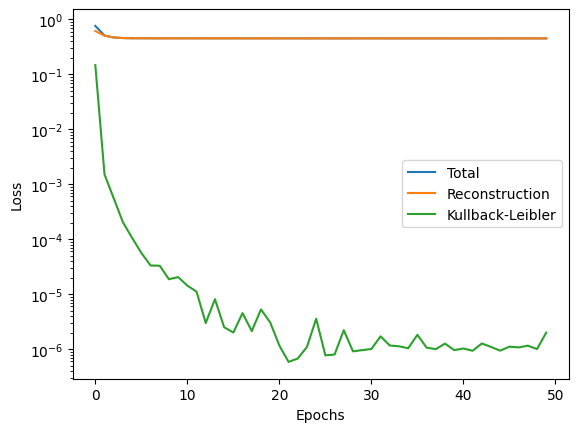

In [31]:
plt.ion()

fig = plt.figure()
plt.semilogy(total_losses, label='Total')
plt.semilogy(recon_losses, label='Reconstruction')
plt.semilogy(kl_losses, label='Kullback-Leibler')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Generation
----------

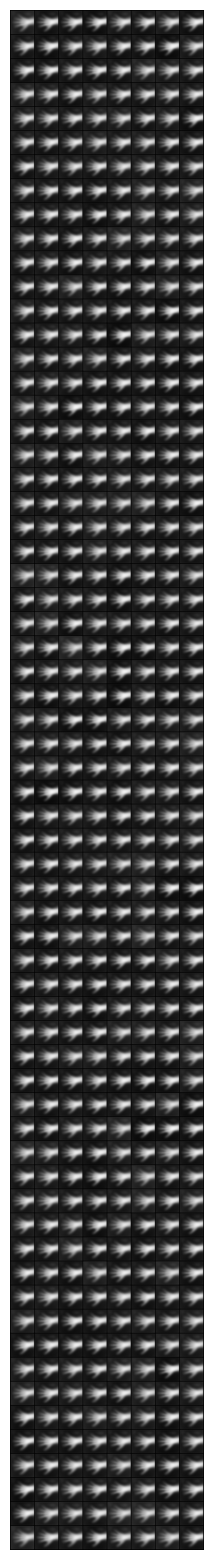

In [32]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

p.eval()
n = 8

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def correct_shape(imgs):
  return imgs.view(n**3, 28, 28).unsqueeze(1)

with torch.no_grad():
    # sample latent vectors from the standard normal distribution
    latent = torch.randn((n**3, latent_dim), device=device)
    fake_image_batch = p(latent)
    fake_image_batch = fake_image_batch.view(-1, 1, 64, 64)
    fake_image_batch = fake_image_batch.cpu()


    fig, ax = plt.subplots(figsize=(20, 20))
    show_image(torchvision.utils.make_grid(fake_image_batch.data,nrow=n))
    plt.axis('off')
    plt.show()

Visualization in Latent Space
-----------------------------

invalid escape sequence '\l'
invalid escape sequence '\l'
invalid escape sequence '\l'


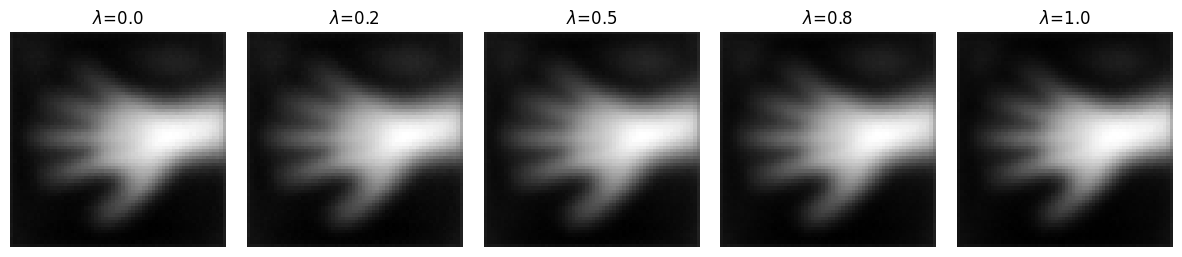

In [33]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

p.eval()

def correct_shape(imgs):
  return imgs.view(-1, 28, 28).unsqueeze(1)

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn((1, latent_dim), device=device)
latent_2 = torch.randn((1, latent_dim), device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,5)

fig, axs = plt.subplots(1,5, figsize=(15, 3))
fig.subplots_adjust(wspace=.1)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), p, latent_1, latent_2)

    #inter_image = correct_shape(inter_image)
    inter_image = inter_image.view(-1, 1, 64, 64)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('$\lambda$='+str(round(l,1)))
    axs[ind].axis('off')
plt.show()